In [1]:
import itertools
import math

try:
    from collections.abc import Generator, Sequence
except ImportError:
    from collections import Sequence, Generator

from typing import Protocol, TypeVar, Union, Generic, Any

import numpy as np
import torch

__all__ = ["TensorDataLoader", "LightDataLoader"]
# ----------------------------------- types ---------------------------------- #
_T_co = TypeVar("_T_co", covariant=True)

class _HasIterDunder(Protocol[_T_co]):
    def __iter__(self) -> _T_co: ...

class _SupportsLenAndGetitem(Protocol[_T_co]):
    def __len__(self) -> int: ...
    def __getitem__(self, __k: int, /) -> _T_co: ...


# ----------------------------- tensor dataloader ---------------------------- #

_TensorOrTuple = TypeVar("_TensorOrTuple", bound=Union[torch.Tensor, Sequence[torch.Tensor]])

class TensorDataLoader(Generic[_TensorOrTuple]):
    def __init__(
        self,
        data: _TensorOrTuple,
        batch_size: int = 1,
        shuffle: bool = False,
        memory_efficient: bool = False,
        seed: Union[int, torch.Generator, None] = None,
    ):
        """A very fast DataLoader for datasets that are fully loaded into memory as tensors.

        Args:
            data (Tensor | Sequence[Tensor]):
                either a single tensor with all samples stacked along the first dimension,
                or a tuple of tensors if each sample has more than one tensor.
                For example, if you have 500 samples of shape (32,32) and 500 labels of shape (10),
                you can pass a tuple of two tensors of the following shapes: `(samples[500, 32, 32], labels[500, 10])`.
            batch_size (int, optional): how many samples per batch to load (default: 1).
            shuffle (bool, optional): set to True to have the data reshuffled at every epoch (default: False).
            memory_efficient (bool, optional):
                enables memory efficient, but slightly slower dataloader.
                During shuffling before each epoch, this uses two times the memory that `data` uses.
                But when `memory_efficient` is enabled, no additional memory will be used (default: False).
            seed (int | torch.Generator | None, optional):
                seed for shuffling, set to None to let pytorch use a random seed.
                Can also be a torch.Generator, but make sure it is on the same device as `data`. Defaults to None.
        """

        self.data: _TensorOrTuple = data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.memory_efficient = memory_efficient

        self._istensor = isinstance(self.data, torch.Tensor)
        self.device = self.data.device if isinstance(self.data, torch.Tensor) else self.data[0].device

        self.seed = seed
        if isinstance(self.seed, torch.Generator): self.generator = self.seed
        elif seed is not None: self.generator = torch.Generator(self.device).manual_seed(seed)
        else: self.generator = None

    def data_length(self):
        ref = self.data if self._istensor else self.data[0]
        return ref.size(0)

    def __len__(self):
        return math.ceil(self.data_length() / self.batch_size)

    def _fast_iter(self) -> Generator[_TensorOrTuple, None, None]:
        if self.shuffle:
            idxs = torch.randperm(self.data_length(), generator = self.generator, device = self.device)
            if self._istensor:
                self.data = torch.index_select(self.data, 0, idxs)
            else:
                self.data = [torch.index_select(i, 0, idxs) for i in self.data]

        if self._istensor:
            yield from self.data.split(self.batch_size)
        else:
            yield from zip(*(i.split(self.batch_size) for i in self.data))

    def _memory_efficient_iter(self) -> Generator[_TensorOrTuple, None, None]:
        if self.shuffle:
            idxs = torch.randperm(self.data_length(), generator = self.generator, device = self.device)

            for batch_indices in idxs.split(self.batch_size):
                if self._istensor:
                    yield self.data[batch_indices]
                else:
                    yield [i[batch_indices] for i in self.data]

    def __iter__(self) -> Generator[_TensorOrTuple, None, None]:
        if self.memory_efficient: return self._memory_efficient_iter()
        return self._fast_iter()

# ----------------------------- light dataloader ----------------------------- #
class _SupportsLenAndGetitems(Protocol[_T_co]):
    def __len__(self) -> int: ...
    def __getitems__(self, __k: Any) -> _T_co: ...

_SampleOrTuple = TypeVar("_SampleOrTuple", bound=Union[torch.Tensor, Any, Sequence[torch.Tensor], Sequence[Any]])

class LightDataLoader(Generic[_SampleOrTuple]):
    def __init__(
        self,
        data: Union[_SupportsLenAndGetitem[_SampleOrTuple], _SupportsLenAndGetitems[_SampleOrTuple]],
        batch_size: int = 1,
        shuffle: bool = False,
        seed: Union[int, np.random.Generator, None] = None,
    ):
        """A lightweight dataloader that collates `data`.

        Args:
            data (Sequence[Tensor | int | float | Any] | Sequence[Sequence[Tensor | int | float | Any]]):
                a sequence of samples. They must either be tensors or tuples of tensors,
                or be convertable to tensors with `torch.as_tensor`, so they can be python ints and floats.

                As in pytorch dataloader, `data` can also be an object with `__getitems__(self, idxs: tuple[int, ...])` method.
                It should be equivalent to `[data[i] for i in idxs]`, but can potentially implement
                paralellization.
            batch_size (int, optional): how many samples per batch to load (default: 1).
            shuffle (bool, optional): set to True to have the data reshuffled at every epoch (default: False).
            seed (int | np.random.Generator | None, optional):
                seed for shuffling, set to None to let numpy use a random seed.
                Can also be a numpy.random.Generator. Defaults to None.
        """
        self.data: _SupportsLenAndGetitem[_SampleOrTuple] = data
        self.batch_size = batch_size
        self.shuffle = shuffle

        self._use_getitems = hasattr(self.data, "__getitems__")

        self.seed = seed
        if isinstance(self.seed, np.random.Generator): self.generator = self.seed
        else: self.generator = np.random.default_rng(seed)

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __iter__(self) -> Generator[_SampleOrTuple, None, None]:

        if self.shuffle: indices = self.generator.permutation(len(self.data))
        else: indices = range(len(self.data))

        for batch_indices in itertools.batched(indices, self.batch_size):
            if self._use_getitems: uncollated_batch = self.data.__getitems__(batch_indices)
            else: uncollated_batch = [self.data[i] for i in batch_indices]
            if isinstance(uncollated_batch[0], torch.Tensor):
                yield torch.stack(uncollated_batch)
            else:
                collated = list(zip(*uncollated_batch))
                yield [torch.stack(i) if isinstance(i[0], torch.Tensor) else torch.as_tensor(i) for i in collated]



In [2]:
from time import perf_counter
from tqdm import tqdm
import matplotlib.pyplot as plt

# download and pre-load CIFAR10 to memory
from torchvision.datasets import CIFAR10
from torchvision.transforms import v2
loader = v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32)])
cifar = list(CIFAR10(r'E:\datasets\CIFAR10', transform = loader, download=False))

time_per_batch_size = {}

In [3]:
images = torch.stack([i[0] for i in cifar])
labels = torch.tensor([i[1] for i in cifar])

# z-normalize
images -= images.mean()
images /= images.std()

images.shape, labels.shape

(torch.Size([50000, 3, 32, 32]), torch.Size([50000]))

# torch.utils.data.TensorDataset with torch.utils.data.DataLoader

In [4]:
from torch.utils.data import TensorDataset, DataLoader
tensor_dataset = TensorDataset(images, labels)

In [5]:
time_per_batch_size['pytorch DataLoader'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  pytorch_dataloader = DataLoader(tensor_dataset, batch_size = batch_size, shuffle = True)

  start = perf_counter()
  for batch in pytorch_dataloader: pass
  time_per_batch_size['pytorch DataLoader'].append(perf_counter() - start)

print(time_per_batch_size['pytorch DataLoader'])

100%|██████████| 128/128 [01:58<00:00,  1.08it/s]

[6.959138399979565, 1.4006462000252213, 1.4363446999923326, 1.4811775000125635, 1.1429774000134785, 0.9584470000118017, 1.2619470999925397, 1.0054417999926955, 1.100856000004569, 0.972091499977978, 1.3327982999908272, 1.0136939999938477, 0.8843859999906272, 1.1379239000089, 1.1006964000116568, 0.8147114000166766, 0.8178631000046153, 0.8140847999893595, 0.8071529000008013, 0.9666077999863774, 0.8332929000025615, 0.8176019999955315, 1.0587896000070032, 0.8519266999792308, 0.8162853000103496, 0.7987876000115648, 0.8251136000035331, 0.811382899992168, 0.8064635999908205, 0.9635211999993771, 0.7906114000070374, 0.8192576000001281, 0.7781558000133373, 0.7978340999979991, 0.800408699986292, 0.8190661999979056, 0.7920423000177834, 0.7901589999964926, 0.7945556000049692, 0.7911712000204716, 0.954141999973217, 0.8152819000242744, 0.7941906999913044, 0.8753337999805808, 0.8213247999956366, 0.8047281999897677, 0.8160138000093866, 0.9494215000013355, 0.8037132999743335, 0.8235532999970019, 0.800663

In [6]:
time_per_batch_size['pytorch DataLoader with pin_memory'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  pytorch_pin_dataloader = DataLoader(tensor_dataset, batch_size = batch_size, shuffle = True, pin_memory = True)

  start = perf_counter()
  for batch in pytorch_pin_dataloader: pass
  time_per_batch_size['pytorch DataLoader with pin_memory'].append(perf_counter() - start)

print(time_per_batch_size['pytorch DataLoader with pin_memory'])

100%|██████████| 128/128 [02:28<00:00,  1.16s/it]

[10.782415699999547, 1.7668769000156317, 1.4635584999923594, 1.2672998000052758, 1.2146913000033237, 1.1038314000179525, 1.052486200002022, 1.020234800002072, 1.016548799991142, 0.9997198000201024, 1.0158447999856435, 0.9984493000083603, 0.9862655000179075, 0.9827068000158761, 0.9774433000129648, 0.9668322000070475, 0.9922148000041489, 0.9997527999803424, 1.0056766000052448, 1.0469942000054289, 0.9975042000005487, 0.9927732999785803, 0.9927000000025146, 1.046779600001173, 1.0236385999887716, 1.042045500013046, 1.1365434000035748, 1.0371237999934237, 1.052473399991868, 1.2213043999799993, 1.045955599984154, 1.0196862000157125, 1.0356899999896996, 1.006936300022062, 1.0540211999905296, 1.0392515000130516, 1.0123819000145886, 1.0394327000249177, 1.0865786999929696, 1.0192010999890044, 1.210469000012381, 1.0403229000221472, 1.0112522999988869, 1.0191200000117533, 1.0275026000163052, 1.0191775000130292, 1.02380070000072, 1.1591292999801226, 1.0121646999905352, 1.037169899995206, 1.037382999

# TensorLoader

In [7]:
from tensorloader import TensorLoader
time_per_batch_size['TensorLoader'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  tensor_dataloader = TensorLoader((images, labels), batch_size = batch_size, shuffle = True)

  start = perf_counter()
  for batch in tensor_dataloader: pass
  time_per_batch_size['TensorLoader'].append(perf_counter() - start)

print(time_per_batch_size['TensorLoader'])

100%|██████████| 128/128 [00:20<00:00,  6.22it/s]

[0.8753040000156034, 0.28821589998551644, 0.23784549999982119, 0.21135540000977926, 0.20027650002157316, 0.19837150000967085, 0.20953200000803918, 0.19238209998002276, 0.1904770999972243, 0.1842700999986846, 0.1936874000239186, 0.17529880002257414, 0.18028010000125505, 0.24083990001236089, 0.16985659999772906, 0.16779289999976754, 0.1720902999804821, 0.16829309999593534, 0.1798939000000246, 0.16410769999492913, 0.16408859999501146, 0.1467873000074178, 0.1610389999987092, 0.14931830001296476, 0.15544619999127463, 0.14792759998817928, 0.15726509998785332, 0.14600809998228215, 0.15100250000250526, 0.1586103000154253, 0.15993349999189377, 0.14840580002055503, 0.15156739999656565, 0.14681520001613535, 0.15720829999190755, 0.14891599997645244, 0.15354329999536276, 0.15616660000523552, 0.15055830002529547, 0.14510209998115897, 0.15405919999466278, 0.14452380000147969, 0.15336560001014732, 0.1468264999857638, 0.15866439999081194, 0.14433509999071248, 0.15155949999461882, 0.14909419999457896, 0

# LightDataLoader

In [8]:
time_per_batch_size['LightDataLoader'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  pytorch_pin_dataloader = LightDataLoader(tensor_dataset, batch_size = batch_size, shuffle = True)

  start = perf_counter()
  for batch in pytorch_pin_dataloader: pass
  time_per_batch_size['LightDataLoader'].append(perf_counter() - start)

print(time_per_batch_size['LightDataLoader'])

100%|██████████| 128/128 [01:48<00:00,  1.18it/s]

[2.1270075000065845, 0.9717208000074606, 0.8322199999820441, 0.7867448999895714, 0.7527187000086997, 0.7540388999914285, 0.7423396999947727, 0.7322903000167571, 0.7676437000045553, 0.7371381999982987, 0.7562429999816231, 0.7349367999995593, 0.7711158999882173, 0.7353031000238843, 0.7293831999995746, 0.7215646000113338, 0.7301030999806244, 0.7352069999906234, 0.732068800018169, 0.7356509999954142, 0.724478900025133, 0.7458152000035625, 0.7303908000176307, 0.762690899980953, 0.7270615999877919, 0.7500352000060957, 0.7441988000064157, 0.7278519000101369, 0.7449576999933925, 0.9311539999907836, 0.7823424999951385, 0.7697141000244301, 0.7477424999815412, 0.7599405999935698, 0.9480700000131037, 0.76845860001049, 0.7748645000101533, 0.7757170000113547, 0.767453199980082, 0.9197151999978814, 0.7721244000131264, 0.7706748000055086, 0.7700836999865714, 0.7598133999854326, 0.7680314000172075, 0.9400962000072468, 0.7725786999799311, 0.7679231000074651, 0.7753514999931213, 0.7821762999810744, 0.933

# TensorDataLoader

In [9]:
time_per_batch_size['TensorDataLoader'] = []

for batch_size in tqdm(range(1, 1024, 8)):
  tensor_dataloader = TensorDataLoader((images, labels), batch_size = batch_size, shuffle = True)

  start = perf_counter()
  for batch in tensor_dataloader: pass
  time_per_batch_size['TensorDataLoader'].append(perf_counter() - start)

print(time_per_batch_size['TensorDataLoader'])

100%|██████████| 128/128 [00:15<00:00,  8.31it/s]

[0.5595178999938071, 0.32646979999844916, 0.13687230000505224, 0.13099309999961406, 0.1247363000002224, 0.12065399999846704, 0.12076790002174675, 0.12214749999111518, 0.12067420000676066, 0.11627619998762384, 0.12038179999217391, 0.11608549999073148, 0.11957700000493787, 0.11568640000768937, 0.12301250000018626, 0.11663889998453669, 0.11745399999199435, 0.1118354000209365, 0.1164889000065159, 0.1175216999836266, 0.11488850001478568, 0.10964300000341609, 0.11612150000291876, 0.11228500001016073, 0.11454850001609884, 0.11075140000320971, 0.11404620000394061, 0.1095762999902945, 0.11624629999278113, 0.10916150000412017, 0.1138273999968078, 0.11694519998854958, 0.11691680000512861, 0.11087800000677817, 0.11575939998147078, 0.11462639999808744, 0.14502050000010058, 0.1516080999863334, 0.11555379998753779, 0.11054320001858287, 0.12202750000869855, 0.1115775000071153, 0.11750220000976697, 0.11772869998821989, 0.11724260001210496, 0.12139700000989251, 0.11738209999748506, 0.11450560000957921, 

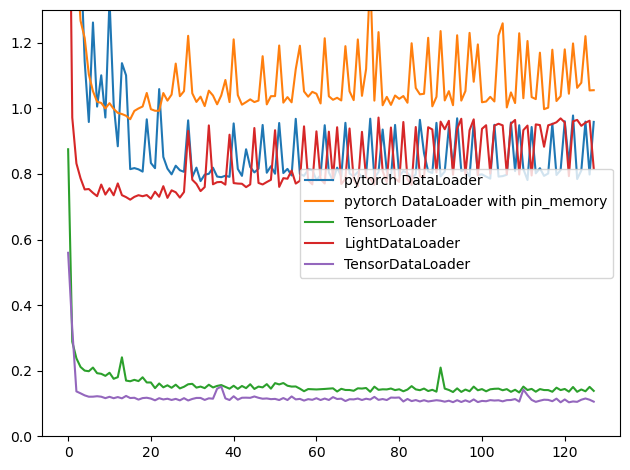

In [11]:
for key, vals in time_per_batch_size.items():
  plt.plot(vals, label = key)

plt.legend()
plt.ylim(0, 1.3)
plt.tight_layout()
plt.show()